In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [2]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt

import pickle

from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

/scratch/guilhoto/anaconda3/envs/new_base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#### Preparing data
data_dict = pickle.load(open('model_data_dictionary_N_Pa.pkl', 'rb'))


# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

print("After grouping all data together, relevant shapes are:")
print(f"us : {us.shape}")
print(f"ys : {ys.shape}")
print(f"fs : {fs.shape}")
print(f"ws : {ws.shape}")

In total there are 22 distinct membranes.
After grouping all data together, relevant shapes are:
us : (188318, 7)
ys : (188318, 1)
fs : (188318, 1)
ws : (188318, 1)


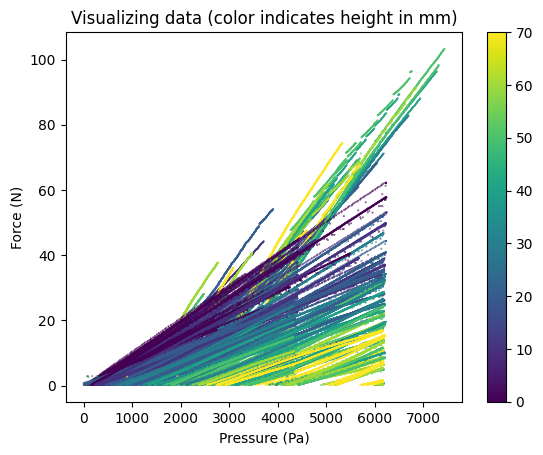

In [4]:
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

## Training Model from Data

In [150]:
%autoreload 2
from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

In [151]:
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [152]:
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))

# Define ensemble
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model
print(model.tabulate())

Initializing model...

                                             RPNEnsemble Summary                                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                 ┃ module            ┃ inputs             ┃ outputs             ┃ params               ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│                      │ RPNEnsemble       │ - float32[10000,7] │ float32[32,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │                      │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble  │ - float32[10000,7] │ float32[64,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │  

In [153]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:10<00:00, 951.30it/s, loss=2.4167712, grad_norm=0.44342858]


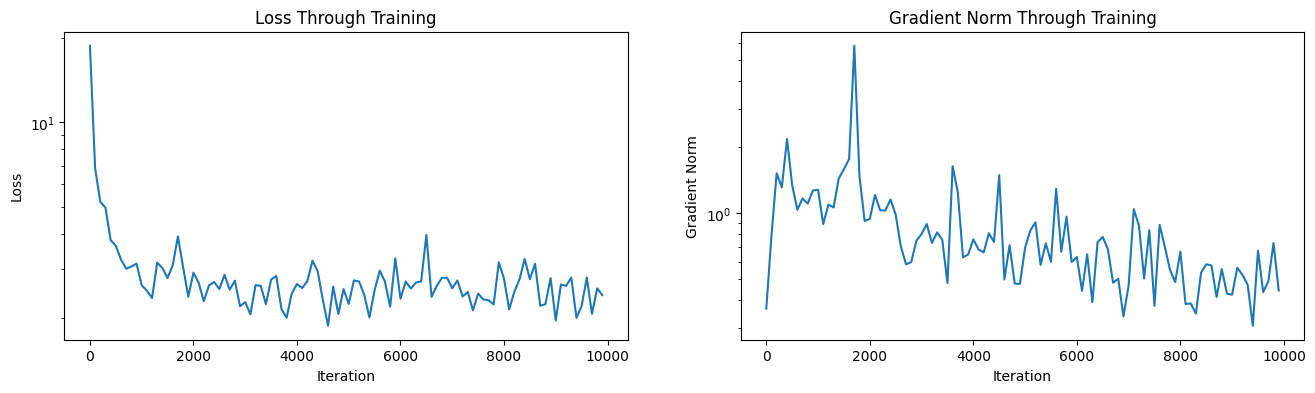

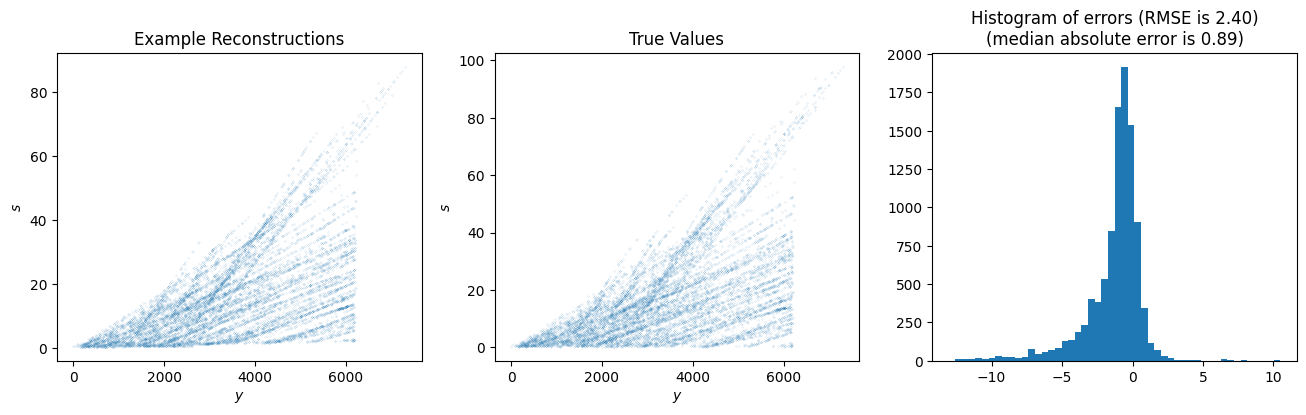

In [154]:
model.plot_training_log()
model.plot_predictions(init_batch)

## Membrane Design Optimization

In [175]:
%autoreload 2
from acquisition import MCAcquisition
from design_optimization import get_trajectory_posterior_fn, get_height_max_posterior_fn
from design_optimization import opt_var_to_phys_var, print_recommendations

In [176]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([14.7, 24.5, 39.24])
target_Ps = jnp.array([6895, 6895, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [177]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


100%|██████████| 5000/5000 [03:12<00:00, 25.97it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [05:16<00:00, 15.79it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [03:39<00:00, 22.79it/s]


In [178]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  28.06
Ring 1) radius:  36.06; width:  5.00
Ring 2) radius:  49.06; width:  5.00


In [179]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -2.78e+02):
Forces obtained are: [28.145351 33.575474 41.636864]
Pressures obtained are: [4409.8135 5229.799  6457.992 ]
Heights obtained are: [6.4069405 4.4000497 2.5096197]

Membrane:
thickness:  2.00
contact radius:  25.40

------------------

Using 1 rings (acquisition score is -3.28e-01):
Forces obtained are: [14.696152 24.491817 39.22672 ]
Pressures obtained are: [6895.5767 6896.328  6897.6753]
Heights obtained are: [66.66718  52.42544  28.188555]

Membrane:
thickness:  2.00
contact radius:  26.57
Ring 1) radius:  43.82; width:  5.00

------------------

Using 2 rings (acquisition score is -2.72e-01):
Forces obtained are: [14.720523 24.478306 39.219364]
Pressures obtained are: [6894.3726 6894.73   6895.8745]
Heights obtained are: [70.       55.463535 33.00017 ]

Membrane:
thickness:  2.00
contact radius:  28.06
Ring 1) radius:  36.06; width:  5.00
Ring 2) radius:  

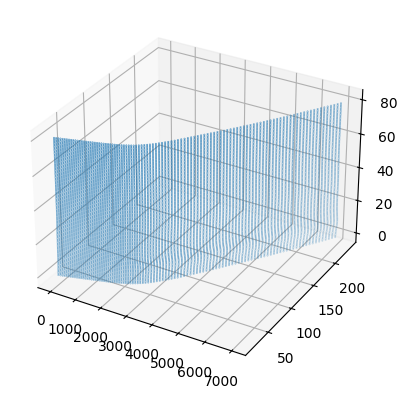

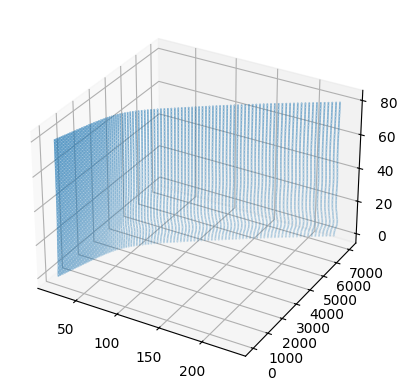

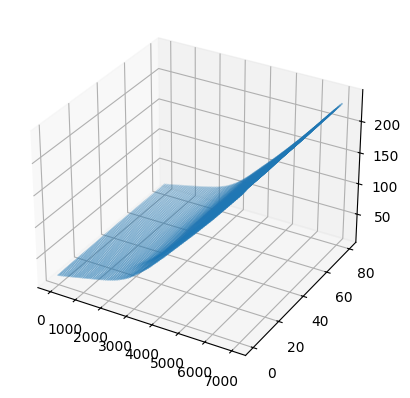

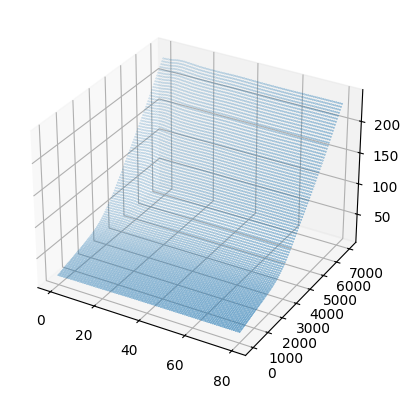

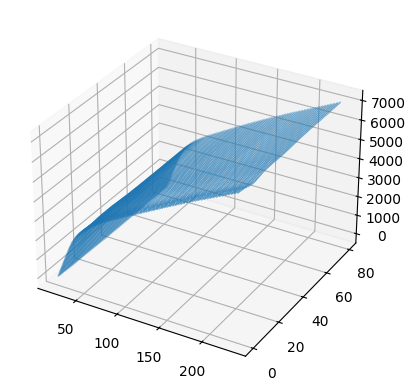

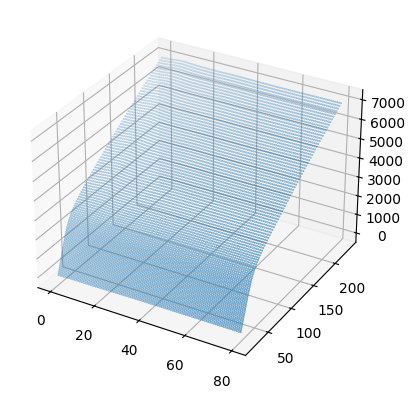

In [180]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()

In [181]:
jnp.isnan(model.apply(model.params, us, ys)).mean()*32

Array(0., dtype=float32)

#### New Optimization

In [182]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([24.5, 24.5, 24.5])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [183]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


  0%|          | 14/5000 [00:00<04:10, 19.92it/s]

100%|██████████| 5000/5000 [03:21<00:00, 24.85it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [05:00<00:00, 16.62it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [03:17<00:00, 25.34it/s]


In [184]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  33.40; width:  5.00
Ring 2) radius:  46.40; width:  5.00


In [185]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -1.11e+02):
Forces obtained are: [25.31563  29.441093 33.594894]
Pressures obtained are: [3986.8386 4604.656  5232.746 ]
Heights obtained are: [8.432164  5.8751793 4.388751 ]

Membrane:
thickness:  2.00
contact radius:  25.40

------------------

Using 1 rings (acquisition score is -4.94e-01):
Forces obtained are: [24.490223 24.493261 24.497135]
Pressures obtained are: [4139.2305 5517.143  6895.6533]
Heights obtained are: [23.9442   37.630543 46.70542 ]

Membrane:
thickness:  2.00
contact radius:  35.41
Ring 1) radius:  46.37; width:  5.00

------------------

Using 2 rings (acquisition score is -4.31e-01):
Forces obtained are: [24.481867 24.491526 24.493477]
Pressures obtained are: [4140.432 5517.909 6896.464]
Heights obtained are: [21.930126 43.782158 59.42958 ]

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  33.40; width:  5.00
Ring 2) radius:  46.

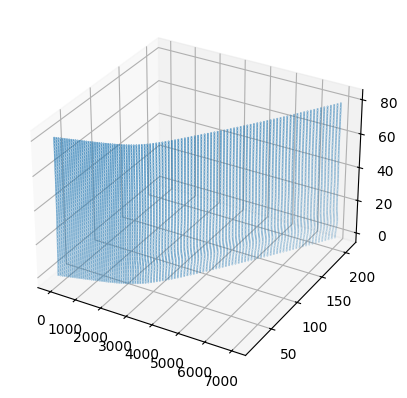

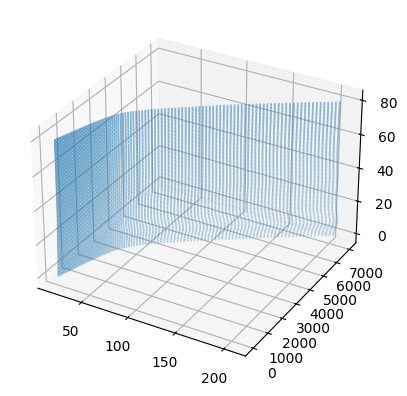

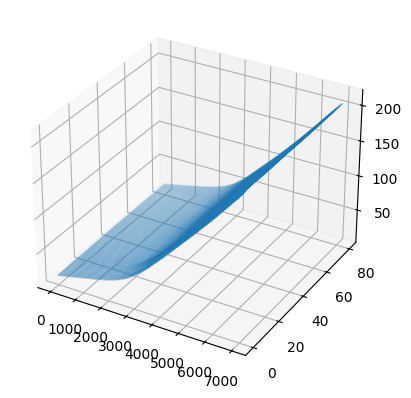

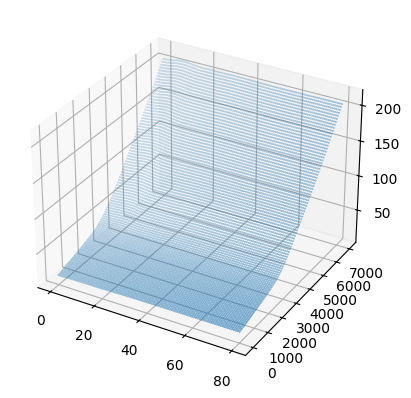

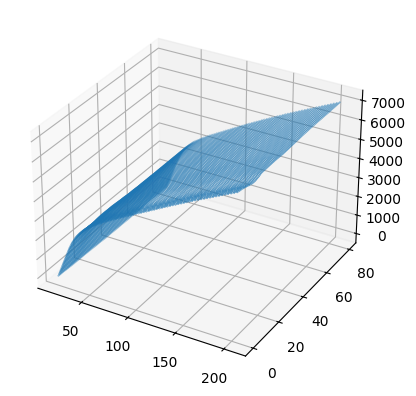

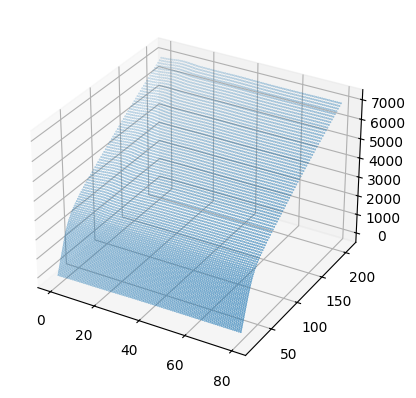

In [186]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()

#### New (new!) Optimization

In [187]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([14.72, 14.72, 14.72])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [188]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


  0%|          | 1/5000 [00:00<38:58,  2.14it/s]

100%|██████████| 5000/5000 [04:33<00:00, 18.29it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [04:46<00:00, 17.44it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [03:06<00:00, 26.80it/s]


In [189]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  28.05
Ring 1) radius:  36.05; width:  5.00
Ring 2) radius:  49.05; width:  5.00


In [190]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -2.15e+02):
Forces obtained are: [15.682848 18.271242 20.851755]
Pressures obtained are: [3684.2585 3835.689  3987.983 ]
Heights obtained are: [62.330994 58.73795  57.02357 ]

Membrane:
thickness:  3.00
contact radius:  38.10

------------------

Using 1 rings (acquisition score is -2.54e-01):
Forces obtained are: [14.706381 14.711167 14.714068]
Pressures obtained are: [4139.4946 5517.545  6895.8823]
Heights obtained are: [37.331562 54.901623 68.24258 ]

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  43.69; width:  5.00

------------------

Using 2 rings (acquisition score is -2.16e-01):
Forces obtained are: [14.705947 14.717184 14.730502]
Pressures obtained are: [4138.4927 5517.427  6894.8213]
Heights obtained are: [40.984566 57.096737 69.99749 ]

Membrane:
thickness:  2.00
contact radius:  28.05
Ring 1) radius:  36.05; width:  5.00
Ring 2) radius:  

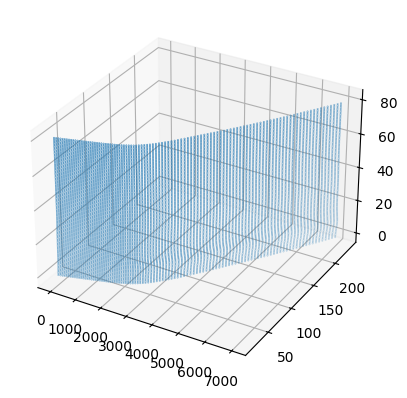

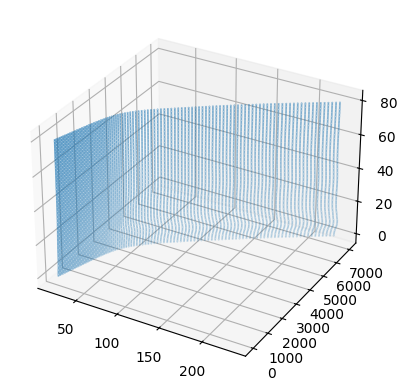

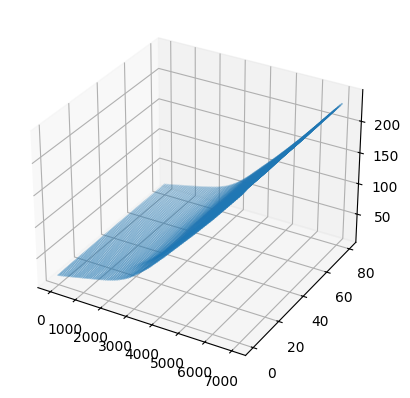

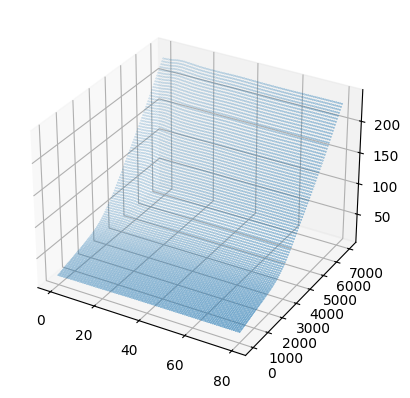

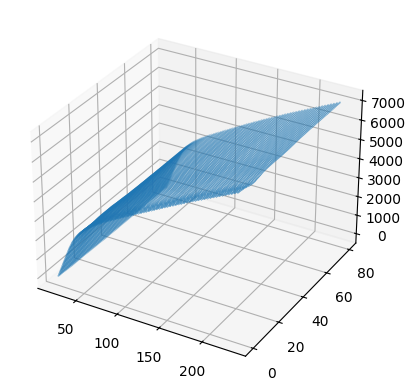

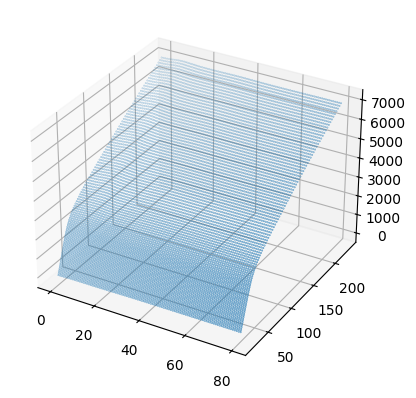

In [191]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()